# 使用教程

`pluto.py`中主要定义了一些类，用于方便读取和处理pluto产生的数据。

使用它之前需要保证你已经安装了以下python模块：
* fire
* numpy
* pandas
* astropy
* matplotlib

如果没有的话请执行以下命令：

In [ ]:
# 根据 requirements.txt文件中所罗列的包，首先使用conda安装，conda如果无法安装就用pip安装
! while read requirement; do conda install --yes $requirement || pip install $requirement; done < requirements.txt

## 声明环境

假定你获取的是整个`skpy`模块包，其中包含了`pluto`模块，即`pluto.py`文件，首先要将`skpy`所在的绝对路径添加到python环境中，将以下路径改成你自己的对应路径。

In [ ]:
import sys
sys.path.append("/Users/xshaokun/Apps/PyMod")

# 声明 $SKPY 指向 skpy 所在的路径
! echo 'export SKPY="$HOME/Apps/PyMod/skpy"' >> ~/.bash_profile

## 导入

In [9]:
import skpy.pluto as pl

## 快速画图预览结果

可以直接在终端用python运行`pluto.py`来快速画图，便于快速预览模拟的结果，当然需要给定一些参数，具体格式如下

    python $SKPY/pluto.py --选项=值 画图函数 数据序列 物理量 --选项=值 - 操作

这样看可能有点复杂，可以先尝试最简单的例子，在你的数据所在目录下执行：

    python $SKPY/pluto.py display 0 rho - show

如果你的模拟是二维的，那么就可以成功画出初始时刻对应的密度分布图。

和前面的格式比较一下，由于这里没有包含任何选项，可以看出每个必要参数分别代表什么。
* 画图函数：目前有二维图函数`display`和一维图函数`line`
* 数据序列：也就是数据对应的编号。可以是*整数编号*；也可以是*浮点数*对应大致的时间，如1.2，会选择对应时间最近的数据来画图；也可以是*负数*，选取最后一个数据
* 物理量：模拟输出的物理量
* 操作：包括：`show`直接跳出窗口显示，`save`会默认保存到当前路径下，文件名为`物理量+数据序列-文件夹名.jpg`，或者通过选项`--name`，指定文件名

需要注意`show`前面的单横线不可忽略，也不能和选项前面的双横线混淆。

### 选项说明

跟在`pluto.py`后面的选项包括：
* `wdir`:指定路径，默认值为`./`，指向当前路径
* `datatype`:数据格式，默认值为`vtk`

跟在物理量后面的选项传递给画图函数使用，具体见下面的原理讲解来理解吧

### 原理讲解

之所以能通过直接运行`pluto.py`来画图是使用了`fire`模块的功能，能让我们将命令行参数传递给python脚本中定义的函数，作为函数的参数并执行。

在`pluto.py`中，定义了一个`Preview`类，因此跟在`pluto.py`后面的选项就会传递给它的`__init__`函数，用于初始化这个类。

后面调用的画图函数也是`Preview`类中定义的方法，后面跟的数据序列和物理量也都是函数需要的必要参数，函数关键字则对应后面的选项，具体可用的关键字选项可以参考函数的文档说明。

## 读取数据

In [10]:
# 指定路径和数据格式
ds = pl.Dataset('/Users/xshaokun/Desktop/sph',datatype='dbl')
ds.info()  # 查看基本信息，可以知道这是二维球坐标模拟，以及模拟使用的单位

wdir           :  /Users/xshaokun/Desktop/sph/
init_file      :  pluto.ini
datatype       :  dbl
filetype       :  single_file
endianess      :  little
geometry       :  SPHERICAL
ndim           :  2
code_unit      :  {'code_density': <Quantity 1.67262171e-24 g / cm3>, 'code_length': <Quantity 3.08e+21 cm>, 'code_velocity': <Quantity 10000000. cm / s>}
field_list     :  ['rho', 'vx1', 'vx2', 'vx3', 'prs']
derived_fields :  {}


`ds`可以通过像列表一样的方式来访问数据。但是像前面讲的一样，这里的索引不仅可以使用正整数，也可以使用浮点数代表大致时间（访问最近的数据），也可以使用负数访问最后一个数据。

In [11]:
# 读取最后一个输出数据
ss = ds[-1]
ss.info() # 查看基本信息，可知这是第4个输出数据，对应时间为1.998521

Reading single data file : /Users/xshaokun/Desktop/sph/data.0004.dbl
nstep          :  4
time           :  1.998521
dt             :  0.002890662
is_quantity    :  False


相关的数据分别以字典的形式保存在以下属性中：
* index: 每个方向的网格数信息
* coord: 每个方向的坐标信息，一维数组
* grid: 多维的坐标数组
* fields: 多维的物理量数组

每个字典可以调用的键值信息如下：

In [14]:
print(ss.index.keys())
print(ss.coord.keys())
print(ss.grid.keys())
print(ss.fields.keys())

dict_keys(['n1', 'n2', 'n3', 'n1_tot', 'n2_tot', 'n3_tot'])
dict_keys(['x1', 'x2', 'x3', 'dx1', 'dx2', 'dx3', 'x1r', 'x2r', 'x3r'])
dict_keys(['x1', 'x2', 'x3', 'dx1', 'dx2', 'dx3', 'x1r', 'x2r', 'x3r'])
dict_keys(['rho', 'vx1', 'vx2', 'vx3', 'prs'])


## 数据切片

In [18]:
rho = ss.fields['rho']
rho.shape

(10, 100)

得到的密度是一个二维数据，但如果我们想知道在$\theta=\pi/2$处，密度随半径的变化，可以使用`.slice1d()`方法：

In [21]:
import numpy as np
rho1d = ss.slice1d('rho', x2=np.pi/2)  # 切片，得到第二维度theta=pi/2处的密度
rho1d.shape

(100,)

这样我们就可以画出一维图：

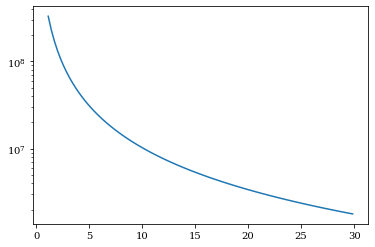

In [22]:
import matplotlib.pyplot as plt
r = ss.coord['x1']  # 半径坐标
plt.plot(r, rho1d)
plt.yscale('log')
plt.show()

同理如果是三维数据需要画二维图像，可以用`.slice2d()`方法来切片

## 单位换算

前面的数据有个问题：虽然数据都是普通浮点数，但是实际上都是基于模拟的单位，即`code_unit`。可以通过`.in_code_unit()`方法来得到带单位的数据：

In [29]:
ss.in_code_unit()  # 给予模拟单位
x1 = ss.coord['x1']  # 获取坐标
print(type(x1))   # 可以看到类型是astropy.units模块下的Quantity
print(x1[0].value, x1[0].unit)   # 单位是code_length

<class 'astropy.units.quantity.Quantity'>
1.145 code_length


也可以使用`.in_astro_unit()`给予常用天文单位：

In [30]:
ss.in_astro_unit()
x1 = ss.coord['x1']
print(type(x1))
print(x1[0].value, x1[0].unit)   # 单位变成了kpc,并且根据单位进行了换算

<class 'astropy.units.quantity.Quantity'>
1.14289322421545 kpc


有了单位，为后续的分析提供了很大的方便，计算其他物理量时不容易出错。我们再次画图：

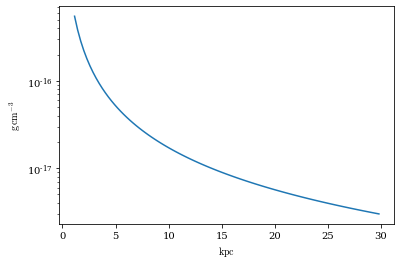

In [32]:
r = ss.coord['x1']  # 半径坐标
rho1d = ss.slice1d('rho', x2=np.pi/2)  # 重新获取密度
plt.plot(r, rho1d)
plt.yscale('log')
plt.show()

也可以进一步进行单位换算：

In [35]:
import astropy.units as u
# 详情见：https://docs.astropy.org/en/stable/units/quantity.html#converting-to-different-units
print(rho1d[0].value,rho1d[0].unit)
rho1d = rho1d.to(u.Msun/u.kpc**3)
print(rho1d[0].value,rho1d[0].unit)

5.515422599758377e-16 g / cm3
8149379071266328.0 solMass / kpc3
